In [23]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


In [90]:
classes = {
    0: "wave",
    1: "circle_cw",
    2: "cirlce_ccw",
    3: "rotate"
}

In [86]:


raw_data_file = "gyro_data.csv"
all_lines = []
with open(raw_data_file, 'r') as file:
    curret_section = None
    section_row_index = None
    for line in file:
        data = line.strip().split(";")

        if len(data) == 3 and data[2] == "sample start":
            curret_section = int(data[0]) - 1
            section_row_index = 0    

        if len(data) == 1 and data[0] == "sample end":
            curret_section = None

        if curret_section is not None and len(data) == 6:
            all_lines.append([section_row_index] + data + [curret_section])
            section_row_index += 1

df = pd.DataFrame(all_lines, columns=["ts", "AcX", "AcY", "AcZ", "GyX", "GyY", "GyZ", "label"])



In [87]:
scaler = MinMaxScaler()
sensor_columns = ["AcX", "AcY", "AcZ", "GyX", "GyY", "GyZ"]
df[sensor_columns] = scaler.fit_transform(df[sensor_columns])
df

,ts,AcX,AcY,AcZ,GyX,GyY,GyZ,label
0,0,0.454399,0.400039,0.632515,0.539104,0.499626,0.493563,0
1,1,0.450783,0.397528,0.648119,0.524840,0.505150,0.488374,0
2,2,0.449980,0.407186,0.627797,0.528511,0.502632,0.495703,0
3,3,0.441409,0.393278,0.643160,0.529979,0.507164,0.497941,0
4,4,0.459488,0.403902,0.633966,0.539838,0.503456,0.498362,0
...,...,...,...,...,...,...,...,...
798,159,0.699210,0.406992,0.550139,0.479810,0.540703,0.536728,3
799,160,0.704701,0.406027,0.565622,0.500612,0.522621,0.489801,3
800,161,0.690639,0.369519,0.616427,0.482782,0.502510,0.490579,3
801,162,0.693317,0.374734,0.578565,0.531133,0.484398,0.474850,3


In [88]:
def plot_gyro_data(df: pd.DataFrame):
    for idx, name in classes.items():
        plt.figure(figsize=(10, 6))
        plt.title(f"Normalized Gyroscope data, class: {name}")
        class_data = df[df["label"] == idx]
        for column in sensor_columns:
            plt.plot(class_data["ts"], class_data[column], label=column)
        plt.legend()
        plt.show()

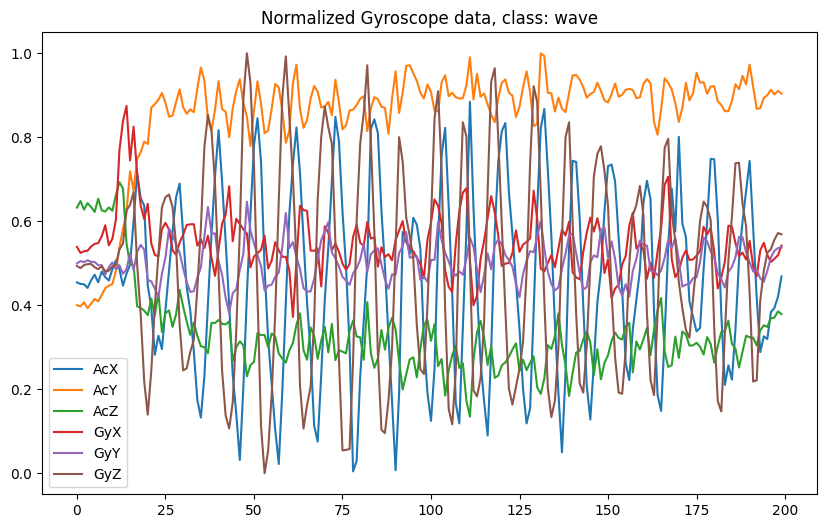

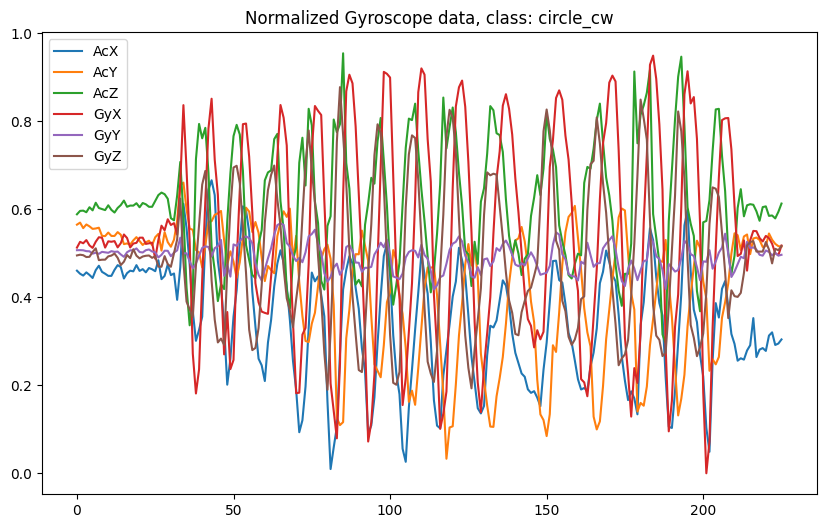

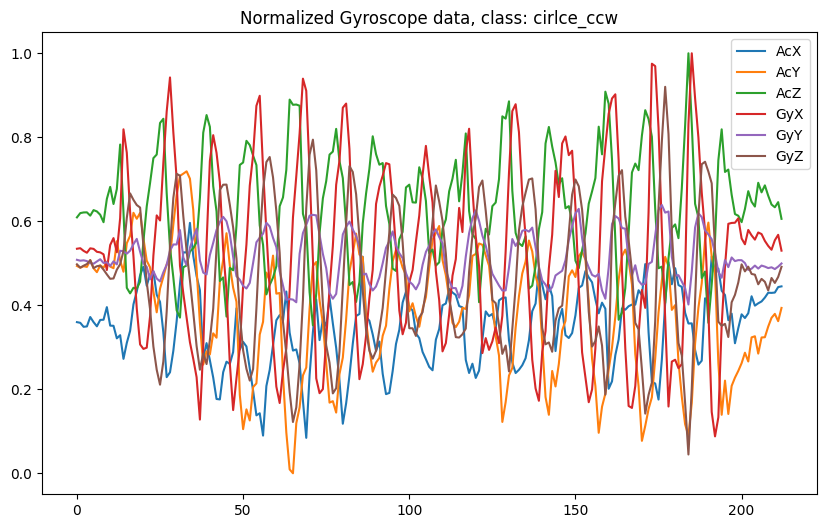

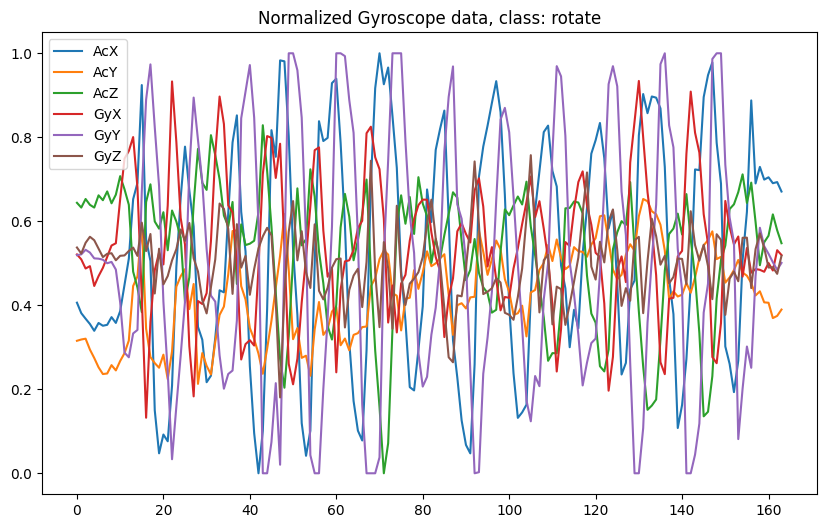

In [115]:
plot_gyro_data(df)

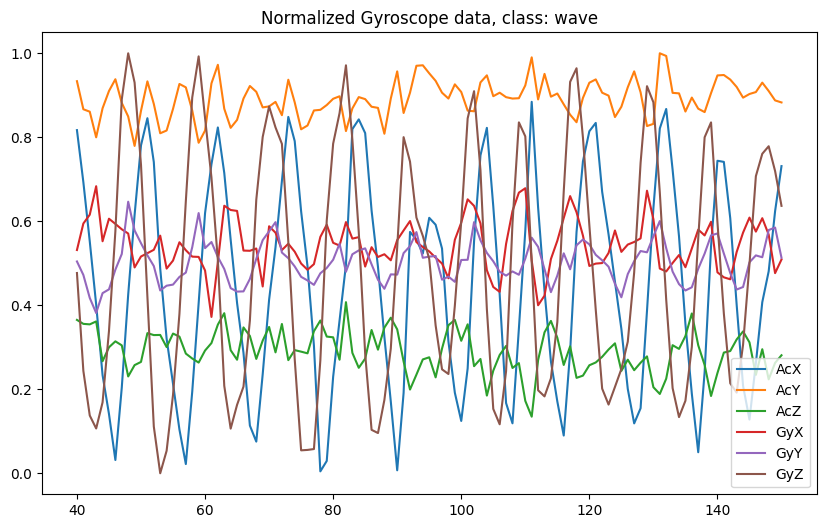

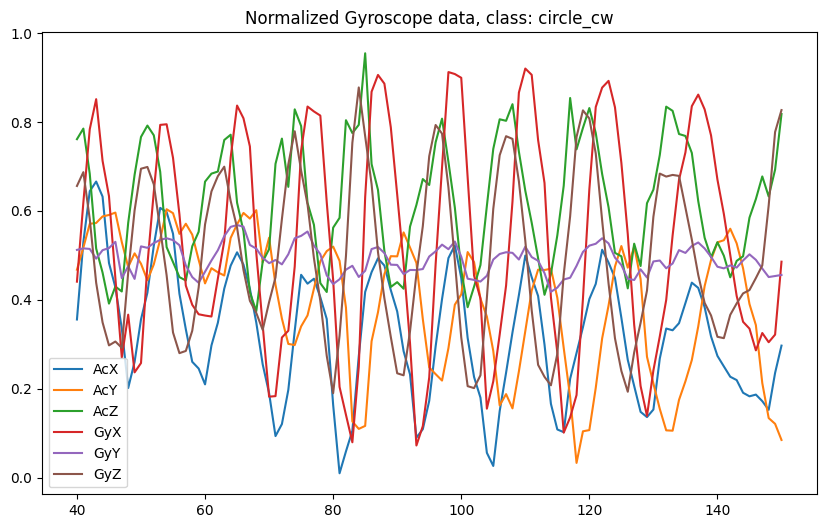

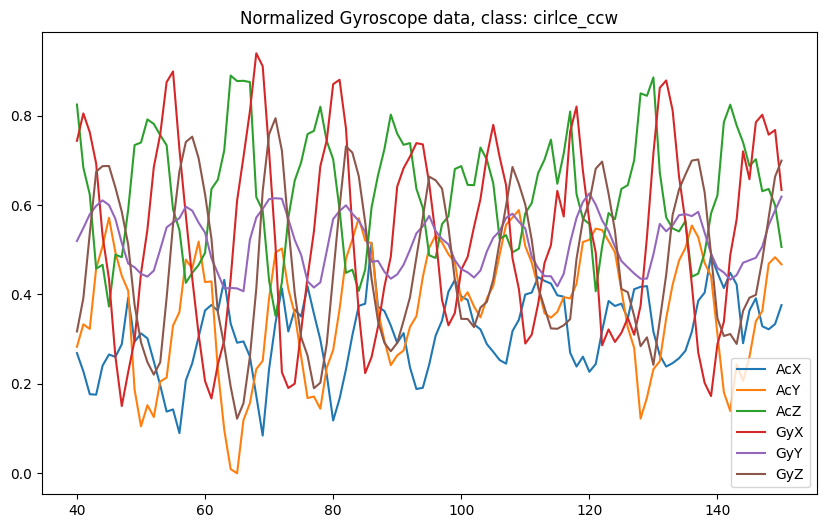

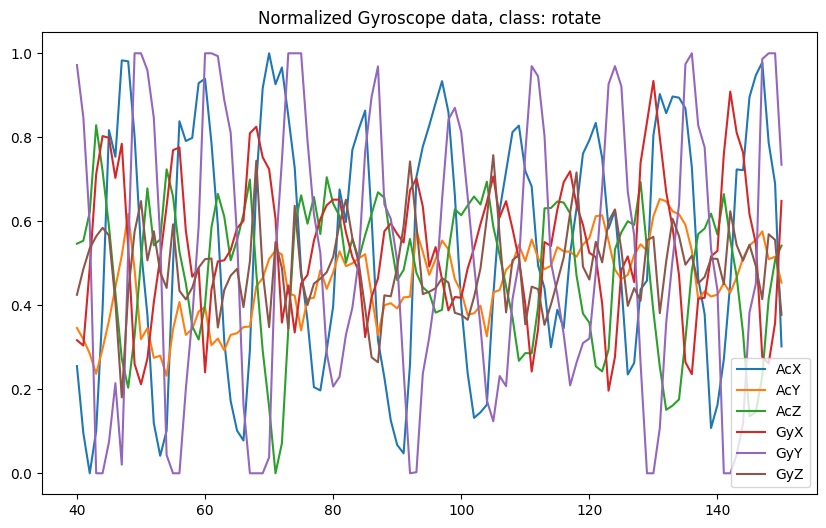

In [117]:
filtered_df = df[(df['ts'] >= 40) & (df['ts'] <= 150)]
plot_gyro_data(filtered_df)

In [118]:
train_test_cutoff = 120

In [92]:
import numpy as np

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.utils import to_categorical

In [119]:
features_train = filtered_df[filtered_df["ts"] < train_test_cutoff][['AcX', 'AcY', 'AcZ', 'GyX', 'GyY', 'GyZ']]
features_test = filtered_df[filtered_df["ts"] >= train_test_cutoff][['AcX', 'AcY', 'AcZ', 'GyX', 'GyY', 'GyZ']]
labels_train = filtered_df[filtered_df["ts"] < train_test_cutoff]["label"]
labels_test = filtered_df[filtered_df["ts"] >= train_test_cutoff]["label"]

In [130]:
time_steps = 10
num_classes = 4

X_train = np.array([features_train[i - time_steps:i].values for i in range(time_steps, len(features_train))])
X_test = np.array([features_test[i - time_steps:i].values for i in range(time_steps, len(features_test))])

y_train = to_categorical(labels_train.values[time_steps:], num_classes=num_classes)
y_test = to_categorical(labels_test.values[time_steps:], num_classes=num_classes)


In [135]:
model = Sequential()
model.add(LSTM(units=10, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(units=num_classes, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [138]:
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))


Epoch 1/50
20/20 [==============================] - 0s 5ms/step - loss: 0.2399 - accuracy: 0.9323 - val_loss: 0.4248 - val_accuracy: 0.8070
Epoch 2/50
20/20 [==============================] - 0s 4ms/step - loss: 0.2234 - accuracy: 0.9484 - val_loss: 0.3773 - val_accuracy: 0.8421
Epoch 3/50
20/20 [==============================] - 0s 4ms/step - loss: 0.2102 - accuracy: 0.9452 - val_loss: 0.4121 - val_accuracy: 0.8246
Epoch 4/50
20/20 [==============================] - 0s 4ms/step - loss: 0.2123 - accuracy: 0.9387 - val_loss: 0.3840 - val_accuracy: 0.8596
Epoch 5/50
20/20 [==============================] - 0s 4ms/step - loss: 0.2055 - accuracy: 0.9484 - val_loss: 0.3731 - val_accuracy: 0.8596
Epoch 6/50
20/20 [==============================] - 0s 4ms/step - loss: 0.2198 - accuracy: 0.9452 - val_loss: 0.3711 - val_accuracy: 0.8421
Epoch 7/50
20/20 [==============================] - 0s 4ms/step - loss: 0.2026 - accuracy: 0.9452 - val_loss: 0.4754 - val_accuracy: 0.8070
Epoch 8/50
20/20 [==

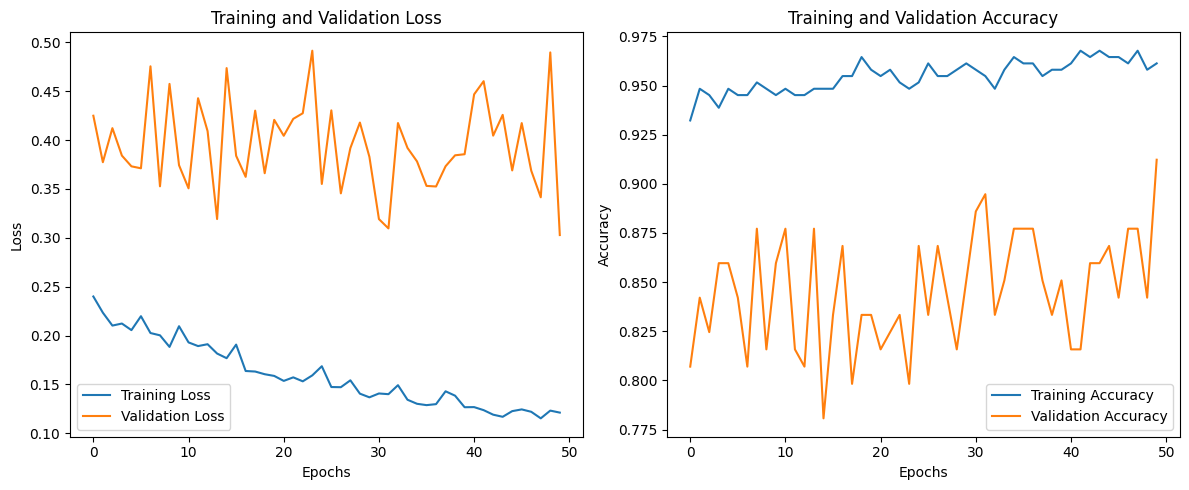

In [139]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()